# Bootstrap

In the attached Excel file you can find data from European money and swap markets for spot date October 3, 2012. Daycount convention is actual/360. Euro denominated swaps have annual paying fixed leg.

Build the discount curve using the bootstrap method explained in the lecture. Report the simple forward rate over the future period October 4, 2041 to October 3, 2042. Express your answer in percentage points and round to 2 decimal places.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [2]:
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
s = date(2012, 10, 3) # spot date

data = """2012/10/4	0.095	LIBOR
2012/11/5	0.116	LIBOR
2013/1/3	0.223	LIBOR
2013/4/3	0.438	LIBOR
2013/6/19	99.786	Futures
2013/9/18	99.752	Futures
2013/12/18	99.723	Futures
2014/3/19	99.669	Futures
2014/10/3	0.475	Swap
2015/10/5	0.586	Swap
2016/10/3	0.752	Swap
2017/10/3	0.942	Swap
2019/10/3	1.324	Swap
2022/10/3	1.739	Swap
2027/10/4	2.165	Swap
2032/10/4	2.280	Swap
2042/10/3	2.332	Swap
"""
LIBOR_data = pd.Series(dtype='float')
Futures_data = pd.Series(dtype='float')
Swap_data = pd.Series(dtype='float')

for line in data.splitlines():
    t, quote, type_ = line.split('\t')
    t = datetime.strptime(t, "%Y/%m/%d").date()
    quote = float(quote)
    if type_ == 'LIBOR':
        simple_rate = quote / 100
        LIBOR_data[t] = simple_rate
    elif type_ == 'Futures':
        futures_rate = (100 - quote) / 100
        Futures_data[t] = futures_rate
    elif type_ == 'Swap':
        swap_rate = quote / 100
        Swap_data[t] = swap_rate

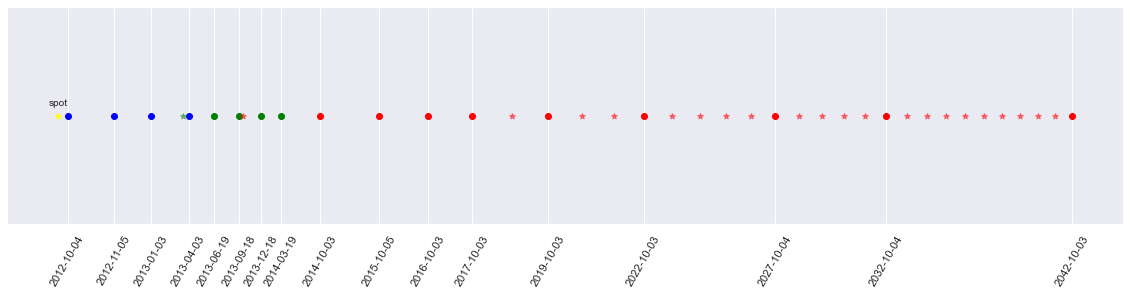

In [4]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.get_yaxis().set_visible(False)


def Show_Time_Data(ax, *time_lists):
    xticks = []
    xticklabels = []
    i = -1
    colors = ['blue', 'green', 'red']
    for time_list in time_lists:
        i += 1
        dt = [np.sqrt((t - s).days) for t in time_list]
        y = np.zeros(len(dt))
        ax.scatter(x=dt, y=y, c=colors[i])
        xticks += dt
        xticklabels += list(time_list)
        if i == 1: # futures
            tmp = time_list[0] - relativedelta(months=3)
            ax.scatter(x=np.sqrt((tmp - s).days), y=0, color=colors[i], alpha=0.5, marker='*')
        if i == 2: # swaps
            tmp = time_list[0] - relativedelta(years=1)
            while tmp.year < 2042:
                ax.scatter(x=np.sqrt((tmp - s).days), y=0, color=colors[i], alpha=0.5, marker='*')
                tmp = tmp + relativedelta(years=1)
                
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=60)
    ax.scatter(x=0, y=0, color='yellow', marker='*') # spot date
    ax.annotate('spot', xy=(0,0), xytext=(-1,0.005))
    
Show_Time_Data(ax, LIBOR_data.keys().values, Futures_data.keys().values, Swap_data.keys().values)

In [5]:
# Building C matrix, p array
# Cd = p

p_list = []
cash_flow_list = [] # each element is a list of cash flows for one instrument
cash_flow_time_list = [] # relative time list

t_set = []

In [6]:
# (1) LIBOR, price=1, pay=1 + r*t

for t, simple_rate in LIBOR_data.items():
    dt = (t - s).days / 360
    pay = 1 + simple_rate * dt
    # update
    p_list.append(1)
    cash_flow_list.append([pay])
    cash_flow_time_list.append([t])
    t_set.append(t)

In [7]:
# (2) Futures, regarded as 3-month FRA
# t1: -1
# t2: 1 + r*t
# price=0
last_t = Futures_data.index[0] - relativedelta(months=3)
t_set.append(last_t)

for t, futures_rate in Futures_data.items():
    dt = (t - last_t).days / 360
    pay = 1 + futures_rate * dt
    # update
    p_list.append(0)
    cash_flow_list.append([-1, pay])
    cash_flow_time_list.append([last_t, t])
    t_set.append(t)
    last_t = t

In [8]:
cash_flow_list

[[1.000002638888889],
 [1.0001063333333333],
 [1.000569888888889],
 [1.0022143333333333],
 [-1, 1.0005468888888889],
 [-1, 1.000626888888889],
 [-1, 1.0007001944444445],
 [-1, 1.0008366944444445]]

In [9]:
# (3) Swap, dt=1 year
# price=1
# cash flow: R*dt_i
import copy

last_t = Swap_data.index[0] - relativedelta(years=1) # first payment

swap_time_list = [last_t] # U1, ..., Uk
swap_dt_list = [(last_t - s).days / 360]  # dt1, ..., dtk

for t, swap_rate in Swap_data.items():
    # years not shown:
    gap = t.year - last_t.year
    for dy in range(1, gap): # if gap=2, then range (1, 2)
        tmp = last_t + relativedelta(years=1)
        swap_time_list.append(tmp)
        swap_dt_list.append((tmp - last_t).days / 360)
        last_t = tmp
    # t
    swap_time_list.append(t)
    swap_dt_list.append((t - last_t).days / 360)
    last_t = t
    
    # given swap_time_list, swap_dt_list at time t
    # build cash flow & p_list
    p_list.append(1)
    this_cash_flow = swap_rate * np.array(swap_dt_list)
    this_cash_flow[-1] = this_cash_flow[-1] + 1
    cash_flow_list.append(this_cash_flow)
    cash_flow_time_list.append(copy.copy(swap_time_list))

t_set += swap_time_list

In [10]:
t_set = sorted(list(set(t_set)))
time2index = {t_set[i]:i  for i in range(len(t_set))}
nRows = len(LIBOR_data) + len(Futures_data) + len(Swap_data)
nCols = len(t_set)

C = np.zeros((nRows, nCols))

for i in range(len(cash_flow_list)):
    cash_flow = cash_flow_list[i] # list
    cash_flow_time = cash_flow_time_list[i] # list
    cash_flow_time = [time2index[x] for x in cash_flow_time]
    C[i: i + 1, cash_flow_time] = cash_flow


In [11]:
tmp = [s] + t_set
tmp = [((tmp[i] - tmp[i-1]).days / 360) ** -0.5 for i in range(1, len(tmp))]
W = np.diag(tmp)
M = np.zeros_like(W)
for i in range(len(M)):
    M[i][i] = 1
    if i != 0:
        M[i][i - 1] = -1

A = C @ np.linalg.inv(M) @ np.linalg.inv(W)
tmp_array = np.zeros((len(M),), dtype='float')
tmp_array[0] = 1
p_array = np.array(p_list, dtype='float')
delta_star = A.T @ np.linalg.inv(A @ A.T) @ (p_array - C @ np.linalg.inv(M) @ tmp_array)

dp_array = delta_star / np.array(tmp, dtype='float')
dp_array

array([-2.63888193e-06, -1.03683146e-04, -4.63242273e-04, -1.59093929e-03,
       -4.89373088e-05, -4.96471747e-04, -6.24800902e-04, -1.23241897e-04,
       -5.74132103e-04, -8.32627511e-04, -4.70851011e-03, -8.10453919e-03,
       -1.23815892e-02, -1.66980720e-02, -2.20128198e-02, -2.16574668e-02,
       -2.50770382e-02, -2.46023043e-02, -2.41971969e-02, -2.56104679e-02,
       -2.52422676e-02, -2.47349337e-02, -2.42977654e-02, -2.39259687e-02,
       -1.89611978e-02, -1.85703567e-02, -1.82322484e-02, -1.78941401e-02,
       -1.76041306e-02, -1.49911968e-02, -1.47045416e-02, -1.44178864e-02,
       -1.41699469e-02, -1.38437907e-02, -1.35571355e-02, -1.32704803e-02,
       -1.30193972e-02, -1.26963846e-02, -1.23757301e-02])

In [12]:
discounted_price_pseudoinverse = pd.Series(dtype='float')
last_p = 1.0
for i in range(len(dp_array)):
    t = t_set[i]
    dp = dp_array[i]
    p = last_p + dp
    discounted_price_pseudoinverse[t] = p
    last_p = p


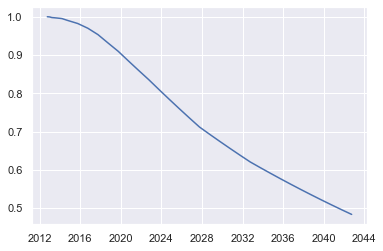

In [13]:
from matplotlib import pyplot as plt
plt.plot(discounted_price_pseudoinverse)

In [14]:
discounted_price_pseudoinverse

2012-10-04    0.999997
2012-11-05    0.999894
2013-01-03    0.999430
2013-03-19    0.997839
2013-04-03    0.997791
2013-06-19    0.997294
2013-09-18    0.996669
2013-10-03    0.996546
2013-12-18    0.995972
2014-03-19    0.995139
2014-10-03    0.990431
2015-10-05    0.982326
2016-10-03    0.969945
2017-10-03    0.953247
2018-10-03    0.931234
2019-10-03    0.909576
2020-10-03    0.884499
2021-10-03    0.859897
2022-10-03    0.835700
2023-10-03    0.810089
2024-10-03    0.784847
2025-10-03    0.760112
2026-10-03    0.735814
2027-10-04    0.711888
2028-10-04    0.692927
2029-10-04    0.674357
2030-10-04    0.656125
2031-10-04    0.638230
2032-10-04    0.620626
2033-10-04    0.605635
2034-10-04    0.590931
2035-10-04    0.576513
2036-10-04    0.562343
2037-10-04    0.548499
2038-10-04    0.534942
2039-10-04    0.521671
2040-10-04    0.508652
2041-10-04    0.495956
2042-10-03    0.483580
dtype: float64

## Question

Build the discount curve using the pseudoinverse method explained in the lecture. Report the simple forward rate over the future period October 4, 2041 to October 3, 2042. Express your answer in percentage points and round to 2 decimal places.  

In [15]:
p1, p2 = discounted_price_pseudoinverse.values[-2], discounted_price_pseudoinverse.values[-1]
t1, t2 = discounted_price_pseudoinverse.index[-2], discounted_price_pseudoinverse.index[-1]
dt = (t2 - t1).days / 360
r = (p1 / p2 - 1) / dt
print(f"{r * 100:.3}")

2.53
